<a href="https://colab.research.google.com/github/Dansah2/Identifying_Age_Related_Conditions/blob/main/1_EDA_ICR__Identifying_Age_Related_Conditions_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICR - Identifying Age-Related Conditions

Kaggle Dataset Download API Command:

kaggle competitions download -c icr-identify-age-related-conditions

Predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

##Project Outline:

1) Download the dataset

2) Explore/Analyze the data

3) Preprocess and organize the data

4) Create and Train baseline Model

5) Save the Model

## Download the Dataset

1) Install required libraries

2) Import required libraries

3) Download data from Kaggle


#### Install Required Libraries

In [ ]:
!pip install -q numpy==1.26.4
!pip install -q -U keras-tuner
!pip install -q -U scikit-learn

#### Import Required Libraries

In [ ]:
# loading and handeling data
import numpy as np
import pandas as pd

# graphing data
pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# downloading data
from google.colab import drive

# check linearity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

#### Download Data From Kaggle


In [ ]:
# Mount google drive to store Kaggle API for future use
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# make a directory for kaggle temporary instance location in Colab
! mkdir ~/.kaggle

In [ ]:
# upload json fine to Google drive and copy the temporary location
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# change the file permissions to read/write to the owner only
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the kaggle data
! kaggle competitions download -c icr-identify-age-related-conditions

  0% 0.00/150k [00:00<?, ?B/s]
100% 150k/150k [00:00<00:00, 125MB/s]


In [ ]:
# unzip the data
! unzip icr-identify-age-related-conditions.zip

Archive:  icr-identify-age-related-conditions.zip
  inflating: greeks.csv              
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# create a function to read the data into a dataframe

def read_function(csv_file):

    return pd.read_csv(csv_file)

raw_train = read_function('/content/train.csv')

## Explore/Analyze the Data
1) Obtain info about the training / testing set.

2) Visulize the data.

3) Ask and answer questions about the data.


###Obtain info about the training / testing set.


Note that all columns except Id and EJ (objects) hold data types float64.

I will remove both Id and EJ for training.

In [ ]:
def show_type(data_frame):
  # obtain data_types
  data_types = data_frame.dtypes.astype(str)

  fig = go.Figure(data=[go.Table(
    header=dict(values=['Column Name', 'Data Type']),
    cells=dict(values=[data_types.index, data_types.values]))])

  # Customize the table layout
  fig.update_layout(
      title='Data Types of DataFrame Columns',
  )

  # Show the plot
  fig.show()

In [ ]:
show_type(raw_train)

In [ ]:
def show_first_n_features(data_frame, n):
    # Select the first n features (columns)
    selected_columns = data_frame.iloc[:, :n]

    # Create a table using Plotly
    fig = go.Figure(data=[go.Table(
        header=dict(values=selected_columns.columns),
        cells=dict(values=[selected_columns[col] for col in selected_columns.columns]))
    ])

    # Customize the table layout
    fig.update_layout(
        title=f'First {n} Features of DataFrame',
    )

    # Show the plot
    fig.show()

# Display the first 5 features of the DataFrame
show_first_n_features(raw_train, n=6)

In [ ]:
def show_stats(data_frame):
  # Calculate summary statistics using describe()
  summary_stats = data_frame.describe()

  # Transpose the summary statistics DataFrame
  summary_stats = summary_stats.transpose()

  # Create a bar chart to visualize summary statistics
  fig = go.Figure(data=[
      go.Bar(name='Mean', x=summary_stats.index, y=summary_stats['mean'], text=summary_stats['mean'], textposition='auto'),
      go.Bar(name='Std', x=summary_stats.index, y=summary_stats['std'], text=summary_stats['std'], textposition='auto'),
      go.Bar(name='Min', x=summary_stats.index, y=summary_stats['min'], text=summary_stats['min'], textposition='auto'),
      go.Bar(name='Max', x=summary_stats.index, y=summary_stats['max'], text=summary_stats['max'], textposition='auto')
  ])

  fig.update_layout(
      title='Summary Statistics',
      xaxis_title='Feature',
      yaxis_title='Value',
      barmode='group',
  )

  fig.show()

show_stats(raw_train)

There are not duplicated values in the dataframe.

Note the following columns and their corresponding null values:

BQ       60, CB        2, CC        3, DU        1, EL       60, FC        1, FL        1, FS        2, GL        1

I will fill these null values with the mean() of their columns.

In [ ]:
def show_missing(data_frame):
  # Calculate the missing values in the DataFrame
  missing_values = data_frame.isna().sum()

  # Create a heatmap
  fig = go.Figure(data=go.Heatmap(
      z=[missing_values.values],  # Provide the missing values as the heatmap data
      x=missing_values.index,     # Feature names as x-axis
      y=["Missing Values"],      # Label for y-axis
      colorscale='Turbo',      # Choose a colorscale (you can customize it)
  ))

  # Add some styling
  fig.update_layout(
      title="Missing Data Heatmap",
      xaxis_title="Features",
      yaxis_title="",
      xaxis_showticklabels=True,
      yaxis_showticklabels=False,
  )

  # Show the plot
  fig.show()

show_missing(raw_train)

In [ ]:
# Create method to count the null values in a particular column and find the percentage of that column
def show_duplicates(data_frame):

  if data_frame.duplicated().sum() == 0:
    print(f'Number of Duplicates:\n {data_frame.duplicated().sum()}')

  duplicates = data_frame[data_frame.duplicated()]

  # Get the counts of each duplicate row
  duplicate_counts = duplicates.groupby(duplicates.columns.tolist()).size().reset_index(name='count')

  # Create a bar chart using Plotly Express
  fig = px.bar(duplicate_counts, x='count', title='Duplicate Rows Count')
  fig.update_layout(xaxis_title="Count", yaxis_title="Frequency")
  fig.show()

show_duplicates(raw_train)

Number of Duplicates:
 0


###Visulize the data.


Note that the data is imbalanced. I will employ class weighting and cross validation to address this issue.

In [ ]:
# create a pie graph that displays the count of each class

def exp_graph_data(data_frame, target_col_name=None):

  print(f"Data shape: {data_frame.shape}\n")
  print(f'Column Names: {list(data_frame.columns)}\n')

  if target_col_name:
    class_counts = data_frame[target_col_name].value_counts()

    print(f'Label Count:\n{class_counts}')

    fig = go.Figure(data=[go.Pie(labels=class_counts.index,
                           values=class_counts.values)])

    fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=10,
                  marker=dict(line=dict(color='#000000', width=2)))

    fig.update_layout(
      title="Number of Samples per Class"
    )

    fig.show()

In [ ]:
exp_graph_data(raw_train, 'Class')

Data shape: (617, 58)

Column Names: ['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class']

Label Count:
0    509
1    108
Name: Class, dtype: int64


There are not any strong correlations with the target variable. (none breaking 50%)

In [ ]:
def coorelation_matrix(data_frame):
  #get correlations of each feature in dataset
  corrmat = data_frame.corr(numeric_only=True)
  top_corr_features = corrmat.index
  plt.figure(figsize=(35,35))
  #plot heat map
  g=sns.heatmap(data_frame[top_corr_features].corr(),annot=True,cmap="RdYlGn")

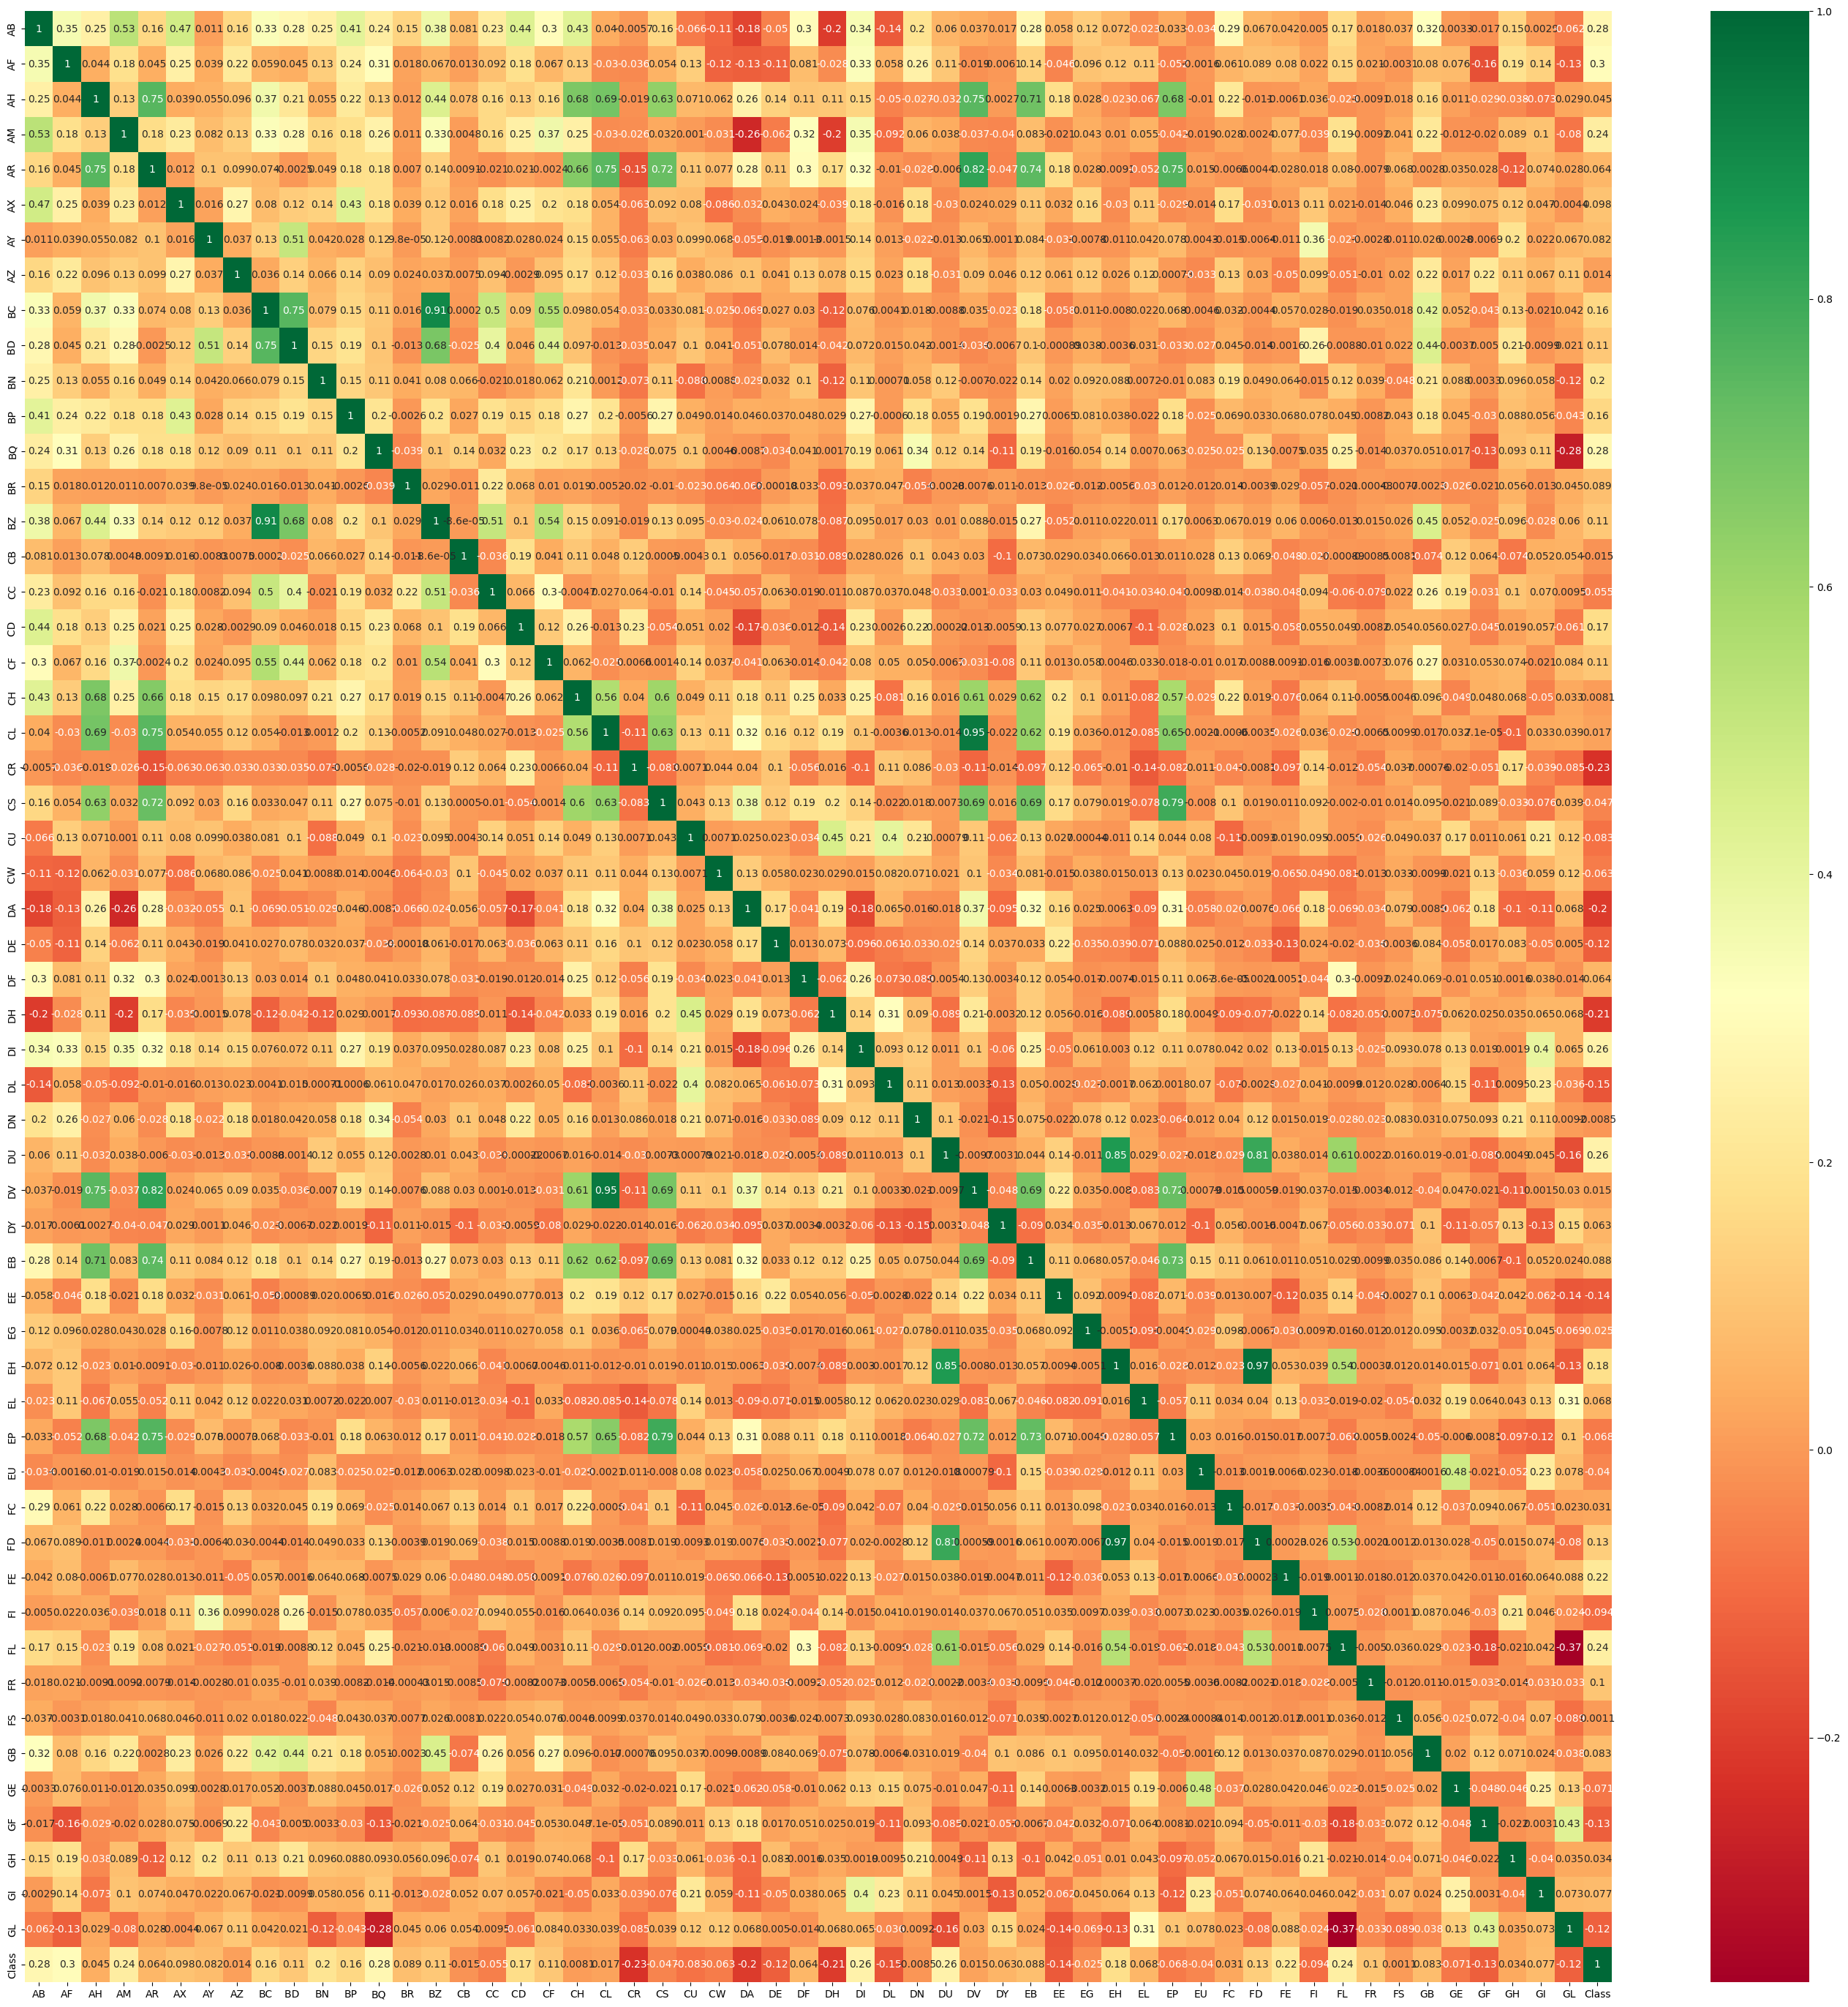

In [ ]:
coorelation_matrix(raw_train)

In [ ]:
def check_linearity(data_frame, target, drop_cols=None):
  # drop unnecessary columns
  if drop_cols:
    data_frame = data_frame.drop(columns=drop_cols)

  # drop any null values
  data_frame = data_frame.dropna()

  # create X and y varialbles
  y = data_frame[target]
  X = data_frame.drop(columns=target)

  # Create a multiple linear regression model
  model = LinearRegression()

  # Fit the model to the data
  model.fit(X, y)

  # Make predictions
  predictions = model.predict(X)

  # Calculate R-squared and mean squared error
  r_squared = r2_score(y, predictions)
  mse = mean_squared_error(y, predictions)

  print(f"R-squared: {r_squared:.2f}")
  print(f"Mean Squared Error: {mse:.2f}")

  # create the residuals
  residuals = y - predictions

  # Create a DataFrame for plotting
  df = pd.DataFrame({'Predicted Values': predictions, 'Residuals': residuals})

  # Create a residual plot using Plotly
  fig = px.scatter(df, x='Predicted Values', y='Residuals', title='Residual Plot')
  fig.add_hline(y=0, line_dash='dash', line_color='red', annotation_text='Zero Residual Line', annotation_position='top right')
  fig.update_layout(xaxis_title='Predicted Values', yaxis_title='Residuals')
  fig.show()

check_linearity(raw_train, 'Class', ['EJ', 'Id'])

R-squared: 0.53
Mean Squared Error: 0.07
